In [ ]:
from adtk.visualization import plot
from adtk.data import validate_series
from adtk.detector import InterQuartileRangeAD

In [3]:
import os,re, glob, csv, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import netCDF4 as nc
from collections import Counter

In [359]:
def avg_daily_sm_data(in_nc = None):
    if in_nc is None:
        in_nc = nc.Dataset(data_path+soil_moisture_path) # read file
    # print(in_nc) # print file information
    # y = in_nc.variables['lat'][:] # read latitude variable
    # x = in_nc.variables['lon'][:] # read longitude variable
    soil_moisture = in_nc.variables['soil_moisture'][:]
    depth = in_nc.variables['depth'][:] # read depth variable
    time = in_nc.variables['time'][:] # read time variable
    time_unit = in_nc.variables["time"].getncattr('units')
    time_cal = in_nc.variables["time"].getncattr('calendar')
    local_time = nc.num2date(time, units=time_unit, calendar=time_cal)
    sm_df = pd.DataFrame(soil_moisture, columns=depth, index=local_time.tolist())
    sm_df['time'] = sm_df.index
    sm_df_daily = sm_df.groupby(pd.Grouper(key='time',freq='1D')).aggregate(lambda x: x.count())
    sm_df_daily['date'] = sm_df_daily.index
    return sm_df_daily

In [360]:
matches_list = [ 'soil_moist_20min_Kendall_AZ_*','soil_moist_20min_Vaira_CA_*','soil_moist_20min_BLMLand1STonzi_CA_*','soil_moist_20min_LuckyHills_AZ_*',
                'soil_moist_20min_MatthaeiGardens_*','soil_moist_20min_NewHoganLakeN_CA_*',
                'soil_moist_20min_TerradOro_CA_*',
                'soil_moist_20min_TonziRanch_CA_*','soil_moist_20min_BLMLand2STonzi_CA_*','soil_moist_20min_BLMLand3NTonzi_CA_*']
data_path = "C:/Users/M Sonakshi/Documents/soil/soil/SoilSCAPE_1339/SoilSCAPE_1339/data/"

In [361]:
match_str = matches_list[0]
f = glob.glob(os.path.join(data_path+match_str))[0]
in_nc = nc.Dataset(os.path.join(data_path, f))
daily_df = avg_daily_sm_data(in_nc)

In [69]:
def isNaN(num):
    return num != num or num==0

In [313]:
def find_longest_seq_count(s1):
    max_val = 0
    longest_gap = 0
    long_seq = 0
    max_long_seq = 0
    num_gaps=0
    no_nulls=True
    for val in s1:
        if isNaN(val):
            if max_val==0:
                num_gaps+=1
            no_nulls=False
            max_val+=1
            if max_long_seq<long_seq:
                max_long_seq = long_seq
            long_seq = 0
        else:
            long_seq+=1
            if longest_gap<max_val:
                longest_gap = max_val
            max_val = 0
    if max_long_seq<long_seq:
        max_long_seq = long_seq
    if longest_gap<max_val:
        longest_gap = max_val
    if no_nulls:
        max_long_seq = s1.shape[0]
    return max_long_seq, longest_gap,num_gaps

In [79]:
def get_data_depth_wise(matches_list):
    list_dict = []
    for match_str in matches_list:
        for f in glob.glob(os.path.join(data_path+match_str)):
            d1 = {}
            site_str = f.split("\\")[1][17:-7]
            d1['site'] = site_str
            in_nc = nc.Dataset(os.path.join(data_path, f))
            daily_df = avg_daily_sm_data(in_nc)
            daily_df = daily_df.replace(0,np.nan)
            node_id = ""
            m = re.match(".*n(\\d+).*", f)
            if m:
                node_id = m.group(1)
                d1['node_id'] = node_id
            daily_df['date'] = pd.to_datetime(daily_df['date'], format='%Y%m%d').apply(lambda x: x.date())
            daily_df.index = daily_df['date']
            d1['total_rows'] = daily_df.shape[0]
            daily_df = daily_df.drop(columns=['date'])
            d1['start'] = list(daily_df.index)[0]
            d1['end'] = list(daily_df.index)[-1]
            gap_dict = {}
            seq_dict={}
            num_gaps = {}
            for col in daily_df.columns:
                seq_dict[col],gap_dict[col],num_gaps[col] = find_longest_seq_count(daily_df[col])
            v = daily_df.isnull().sum()
            depth_null = list(zip(v.index,v))
            for a in depth_null:
                d = d1.copy()
                d['depth'] = a[0]
                d['nulls'] = a[1]
                d['filled_percentage'] = 1 - d['nulls']/float(d['total_rows'])
                d['longest_gap'] = gap_dict[a[0]]
                d['longest_seq'] = seq_dict[a[0]]
                d['num_gaps']  = num_gaps[a[0]]
                list_dict.append(d)
    with open("C:/Users/M Sonakshi/Documents/soil_imgs/countVis/nodewisedata.csv",'w',newline="") as f:
        keys = list_dict[0].keys()
        writer = csv.DictWriter(f,['site','node_id','depth','start','end','nulls','total_rows','filled_percentage','longest_gap','longest_seq','num_gaps'])
        writer.writeheader()
        writer.writerows(list_dict)
                

In [80]:
get_data_depth_wise(matches_list)

In [81]:
data = pd.read_csv("C:/Users/M Sonakshi/Documents/soil_imgs/countVis/nodewisedata.csv")

In [314]:
data.head()

,site,node_id,depth,start,end,nulls,total_rows,filled_percentage,longest_gap,longest_seq,num_gaps
0,Kendall_AZ_n,1400,5,2015-08-16,2019-03-26,59,1319,0.955269,11,463,18
1,Kendall_AZ_n,1400,15,2015-08-16,2019-03-26,68,1319,0.948446,11,463,20
2,Kendall_AZ_n,1400,30,2015-08-16,2019-03-26,59,1319,0.955269,11,463,18
3,Kendall_AZ_n,1401,5,2015-08-16,2019-03-26,210,1319,0.840788,150,340,20
4,Kendall_AZ_n,1401,15,2015-08-16,2019-03-26,844,1319,0.360121,808,223,4


In [83]:
data[data['filled_percentage']==1]['total_rows'].sum()/data['total_rows'].sum()

0.01734368903849818

In [84]:
data[data['filled_percentage']>=0.9]['total_rows'].sum()/data['total_rows'].sum()

0.10614446571638554

In [85]:
data[data['filled_percentage']>=0.8]['total_rows'].sum()/data['total_rows'].sum()

0.1961141910059007

In [86]:
data[data['filled_percentage']>=0.7]['total_rows'].sum()/data['total_rows'].sum()

0.3497258339155393

In [87]:
data[data['filled_percentage']>=0.6]['total_rows'].sum()/data['total_rows'].sum()

0.5184249286986714

In [93]:
data[(data['longest_seq']>=300)]['longest_seq'].sum()

125915

In [89]:
data[data['filled_percentage']<=0.1]['total_rows'].sum()/data['total_rows'].sum()

0.019011671339436667

In [90]:
data['total_rows'].sum()

661278

In [335]:
df = pd.read_csv("C:/Users/M Sonakshi/Documents/soil/soil/pred_exp/merge_all_result.csv",sep=";")

In [336]:
df = df.sort_values(by=['date'])

In [134]:
##soil moisture values for these were only equal to 0.1 - hence best to discard
cols_discard =['Vaira_CAn=642_d=5',
 'Vaira_CAn=644_d=5',
 'Vaira_CAn=651_d=5',
 'Vaira_CAn=651_d=20',
 'Vaira_CAn=653_d=5',
 'Vaira_CAn=656_d=5',
 'Vaira_CAn=656_d=20',
 'Vaira_CAn=661_d=5',
 'Vaira_CAn=666_d=5',
 'Vaira_CAn=666_d=20',
 'Vaira_CAn=668_d=5',
 'Vaira_CAn=670_d=5',
 'Vaira_CAn=671_d=20',
 'Vaira_CAn=675_d=5',
 'Vaira_CAn=675_d=20',
 'LuckyHills_AZ_n=1502_d=50']

In [337]:
filtered = df

In [338]:
filtered.index = filtered.date

In [112]:
filtered=filtered.replace(0,np.nan)

In [339]:
def get_dates_filter(s1,dates):
    max_val = 0
    longest_gap = 0
    long_seq = 0
    max_long_seq = 0
    no_nulls=True
    gaps = []
    starts = []
    ends = []
    mls_start = []
    mls_end = []
    seqs=[]
    for val,date in zip(s1,dates):
        if isNaN(val):
            no_nulls=False
            if max_val ==0:
                starts.append(date)
            max_val+=1
            if max_long_seq<long_seq:
                max_long_seq = long_seq
            if long_seq > 0:
                seqs.append(long_seq)
                mls_end.append(date)
            long_seq = 0
        else:
            if long_seq ==0:
                mls_start.append(date)
            long_seq+=1
            if longest_gap<max_val:
                longest_gap = max_val
            if max_val > 0:
                gaps.append(max_val)
                ends.append(date)
            max_val = 0
    if max_long_seq<long_seq:
        max_long_seq = long_seq
    if longest_gap<max_val:
        longest_gap = max_val
    if max_val>0:    
        ends.append(dates[-1])
        gaps.append(max_val)
    if no_nulls:
        max_long_seq = s1.shape[0]
    if long_seq > 0:
        mls_end.append(dates[-1])
        seqs.append(long_seq)
    d = dict()
    d['gaps'] = gaps
    d['starts'] = starts
    d['ends'] = ends
    d['mls_start'] = mls_start
    d['mls_end'] = mls_end
    d['seqs'] = seqs
    d['long_seq'] = max_long_seq
    d['longest_gap'] = longest_gap
    return d

In [342]:
d1 =get_dates_filter(filtered['BLMLand1STonzi_CAn=900_d=5'],list(filtered.date))


In [ ]:
d1

{'ends': ['2013-07-05',
  '2013-08-06',
  '2013-09-28',
  '2015-08-18',
  '2015-08-21',
  '2015-09-02',
  '2015-09-06',
  '2015-09-11',
  '2015-09-19',
  '2015-09-21',
  '2015-10-02',
  '2015-11-02',
  '2016-01-08',
  '2016-02-24',
  '2016-03-26',
  '2016-05-28',
  '2016-09-27',
  '2017-08-06',
  '2018-01-11',
  '2018-02-23',
  '2018-03-12',
  '2018-10-02',
  '2018-11-24',
  '2018-11-30',
  '2018-12-02',
  '2018-12-06',
  '2019-09-01',
  '2019-11-15'],
 'gaps': [322,
  1,
  22,
  1,
  2,
  8,
  2,
  4,
  7,
  1,
  10,
  30,
  37,
  17,
  1,
  2,
  1,
  172,
  1,
  1,
  3,
  203,
  52,
  5,
  1,
  3,
  268,
  75],
 'long_seq': 688,
 'longest_gap': 322,
 'mls_end': ['2013-08-05',
  '2013-09-06',
  '2015-08-17',
  '2015-08-19',
  '2015-08-25',
  '2015-09-04',
  '2015-09-07',
  '2015-09-12',
  '2015-09-20',
  '2015-09-22',
  '2015-10-03',
  '2015-12-02',
  '2016-02-07',
  '2016-03-25',
  '2016-05-26',
  '2016-09-26',
  '2017-02-15',
  '2018-01-10',
  '2018-02-22',
  '2018-03-09',
  '2018-0

In [348]:
def get_long_seq_tup(d1):
    for tup in list(zip(d1['seqs'],d1['mls_start'],d1['mls_end'])):
        if d1['long_seq'] == tup[0]:
            return tup

        
def index_for_gaps(d1,seq_start,seq_end):
    start_gap = None
    end_gap = None
    for i,tup in enumerate(list(zip(d1['gaps'],d1['starts'],d1['ends']))):
        if seq_start == tup[2]:
            start_gap = i
        if seq_end == tup[1]:
            end_gap = i
        if start_gap and end_gap:
            return start_gap, end_gap
    return start_gap, end_gap

def get_modified_start_date_for_seq(seq_gaps, start_gap):
    start_seq = None
    for i in reversed(range(start_gap+1)):
        if seq_gaps[i][0] < 45:
            if i>0:
                start_seq = seq_gaps[i-1][2]
            else:
                start_seq = seq_gaps[i][1]
        else:
            return start_seq
    return start_seq


def get_modified_seq_end_date(seq_gaps,end_gap):
    end_seq = None
    for i in range(end_gap,len(seq_gaps)):
        if seq_gaps[i][0] < 45:
            if i < len(seq_gaps)-1:
                end_seq = seq_gaps[i+1][1]
            else:
                end_seq = seq_gaps[i][2]
        else:
            return end_seq
    return end_seq

In [351]:
col ='TerradOro_CA_n=1307_d=5'


In [352]:
sample = filtered[col]
d1 =get_dates_filter(filtered[col],list(filtered.index))
seq_tuple = list(zip(d1['seqs'],d1['mls_start'],d1['mls_end']))
seq_gaps = list(zip(d1['gaps'],d1['starts'],d1['ends']))
if seq_tuple:
    _,seq_start,seq_end = get_long_seq_tup(d1)
    start_gap, end_gap = index_for_gaps(d1, seq_start,seq_end)
    if start_gap:
        start_seq_modified = get_modified_start_date_for_seq(seq_gaps,start_gap)
        if start_seq_modified:
            seq_start = start_seq_modified
    if end_gap:
        end_seq_modified = get_modified_seq_end_date(seq_gaps,end_gap)
        if end_seq_modified:
            seq_end = end_seq_modified
    res_tup.append((col,seq_start,seq_end))

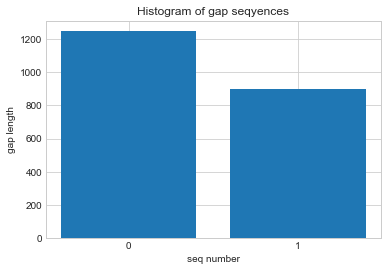

In [355]:
x = [str(i) for i in range(len(d1['gaps']))]
plt.bar(x,d1['gaps'])  # arguments are passed to np.histogram
plt.title("Histogram of gap seqyences")
plt.xlabel('seq number')
plt.ylabel('gap length')
plt.show()

In [354]:
d1['gaps']

[1246, 900]

In [371]:
## retrieving the start and end dates for each node
try:
    res_tup = []
    list_cols = list(filtered.columns)
    list_cols.remove('date')
    for col in list_cols:
        sample = filtered[col]
        sample = sample.dropna()
        if not sample.empty and sample.shape[0]>10:
            sample.index = pd.to_datetime(sample.index)
            s1 =sample.resample('D').mean()
            d1 =get_dates_filter(s1,list(filtered.index))
            seq_tuple = list(zip(d1['seqs'],d1['mls_start'],d1['mls_end']))
            seq_gaps = list(zip(d1['gaps'],d1['starts'],d1['ends']))
            if seq_tuple:
                _,seq_start,seq_end = get_long_seq_tup(d1)
                start_gap, end_gap = index_for_gaps(d1, seq_start,seq_end)
                if start_gap:
                    start_seq_modified = get_modified_start_date_for_seq(seq_gaps,start_gap)
                    if start_seq_modified:
                        seq_start = start_seq_modified
                if end_gap:
                    end_seq_modified = get_modified_seq_end_date(seq_gaps,end_gap)
                    if end_seq_modified:
                        seq_end = end_seq_modified
                res_tup.append((col,seq_start,seq_end))
                
                # x = [str(i) for i in range(len(d1['gaps']))]
                plt.figure(figsize=(20, 10))
                fig = plt.gcf()
                plt.bar(d1['starts'], d1['gaps'],align='center', width=0.3)
                plt.title("Histogram of gap sequences of {}".format(col))
                plt.xlabel('gap start date')
                plt.ylabel('gap length')
                fig.autofmt_xdate()
                fig.savefig('C:/Users/M Sonakshi/Documents/soil_imgs/gaps_hist/'+col+".png")
                plt.close('all') 
    resdf = pd.DataFrame(res_tup,columns =['node','start_date','end_date'])
    resdf.to_csv("C:/Users/M Sonakshi/Documents/soil_imgs/gaps_hist/sequence_date.csv",index=None)
except Exception as e:
    print(e)

In [309]:
def find_longest_seq_count(s1):
    max_val = 0
    longest_gap = 0
    long_seq = 0
    max_long_seq = 0
    num_gaps=0
    no_nulls=True
    for val in s1:
        if isNaN(val):
            if max_val==0:
                num_gaps+=1
            no_nulls=False
            max_val+=1
            if max_long_seq<long_seq:
                max_long_seq = long_seq
            long_seq = 0
        else:
            long_seq+=1
            if longest_gap<max_val:
                longest_gap = max_val
            max_val = 0
    if max_long_seq<long_seq:
        max_long_seq = long_seq
    if longest_gap<max_val:
        longest_gap = max_val
    if no_nulls:
        max_long_seq = s1.shape[0]
    return max_long_seq, longest_gap,num_gaps

In [107]:
## plotting the outliers for each node and saving the stats of gaps, filled sequences to a csv file
s1=None
outlier_list =[]
try:
    list_dict = []
    list_cols = list(filtered.columns)
    list_cols.remove('date')
    for col in list_cols:
        d1={}
        sample = filtered[col]
        sample = sample.dropna()
        if not sample.empty and sample.shape[0]>10:
            sample.index = pd.to_datetime(sample.index)
            d1['site'] = col.split("n=")[0]
            node_id = col.split("n=")[1].split("_")[0]
            d1['depth'] = col.split("n=")[1].split("_d=")[1]
            s1 =sample.resample('D').mean()
            s = validate_series(s1)
            iqr_ad = InterQuartileRangeAD(c=1.5)
            anomalies = iqr_ad.fit_detect(s)
#             a=anomalies[~isNaN(anomalies)]
#             a=a[a>0]
#             if not a.empty:
#                 s = s.dropna()
#                 s[s.index.isin(list(a.index))] = np.nan
#                 s = pd.DataFrame(s)
#                 s = s.assign(InterpolateTime=s.interpolate(method='time'))
#                 s[col] = sample
#                 anomalies1 = iqr_ad.fit_detect(s)
#                 if anomalies1[anomalies1.InterpolateTime>0]['InterpolateTime'].shape[0]>0:
            plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");
            fig = plt.gcf()
            plt.xlabel('date')
            plt.ylabel('soil moisture')
            plt.title("SITE = " + d1['site']+ ",  NODE_ID = " + node_id + ",  DEPTH = "+d1['depth'])
            fig.savefig('C:/Users/M Sonakshi/Documents/soil_imgs/countVis/'+col+".png")
            plt.close('all')           
            d1['node_id'] = node_id
            d1['total_rows'] = s1.shape[0]
            d1['start'] =  s1.index[0].date()
            d1['end'] =  s1.index[-1].date()
            max_long_seq, longest_gap,num_gaps = find_longest_seq_count(s1)
            d1['nulls'] = s1.isnull().sum()
            d1['filled_percentage'] = 1 - d1['nulls']/float(d1['total_rows'])
            d1['longest_gap'] = longest_gap
            d1['longest_seq'] = max_long_seq
            d1['num_gaps'] = num_gaps
            list_dict.append(d1)
    with open("C:/Users/M Sonakshi/Documents/soil_imgs/countVis/nodewisefiltered.csv",'w',newline="") as f:
        keys = list_dict[0].keys()
        writer = csv.DictWriter(f,['site','node_id','depth','start','end','nulls','total_rows','filled_percentage','longest_gap','longest_seq','num_gaps'])
        writer.writeheader()
        writer.writerows(list_dict)
except Exception as e:
    print(e)
#     print(s1)
                

In [181]:
len(outlier_list)

357

In [182]:
len(list_cols)

603

In [310]:
data = pd.read_csv("C:/Users/M Sonakshi/Documents/soil_imgs/docs/nodewisefiltered.csv")

In [311]:
data[ (data['longest_seq']>=300)].head()

,site,node_id,depth,start,end,nulls,total_rows,filled_percentage,longest_gap,longest_seq
0,TerradOro_CA_,1303,5,2016-01-14,2017-05-29,1,502,0.998008,1,500
5,BLMLa,903,20,2013-07-06,2019-09-01,858,2249,0.618497,268,411
6,TerradOro_CA_,1317,-992,2016-01-14,2017-09-28,121,624,0.806090,121,502
8,TerradOro_CA,817,15,2013-04-06,2015-03-18,186,712,0.738764,72,302
11,TerradOro_CA_,1308,30,2016-01-14,2017-05-29,1,502,0.998008,1,500


In [323]:
data[data['filled_percentage']==1]['total_rows'].sum()/data['total_rows'].sum()

0.02149260616942221

In [313]:
data[data['filled_percentage']>=0.9]['total_rows'].sum()/data['total_rows'].sum()

0.11467918505772923

In [324]:
data['total_rows'].sum()

641616

In [314]:
data[data['filled_percentage']>=0.8]['total_rows'].sum()/data['total_rows'].sum()

0.20298589810727913

In [315]:
data[data['filled_percentage']>=0.7]['total_rows'].sum()/data['total_rows'].sum()

0.36185974165232787

In [316]:
data[data['filled_percentage']>=0.6]['total_rows'].sum()/data['total_rows'].sum()

0.5350567940949104

In [325]:
data[(data['longest_seq']>=300)]['longest_seq'].sum()

125915

In [439]:
data[data['filled_percentage']<=0.1]['total_rows'].sum()/data['total_rows'].sum()

0.017973536307593865

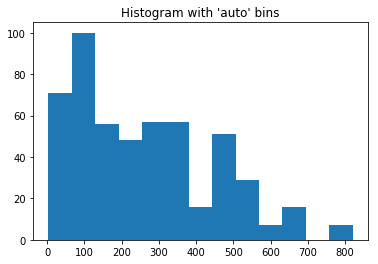

In [440]:
_ = plt.hist(data[data['filled_percentage']<1.0]['longest_seq'], bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

can't multiply sequence by non-int of type 'float'
date
2011-08-03    2011-08-03
2011-08-04    2011-08-04
2011-08-05    2011-08-05
2011-08-06    2011-08-06
2011-08-07    2011-08-07
2011-08-08    2011-08-08
2011-08-09    2011-08-09
2011-08-10    2011-08-10
2011-08-11    2011-08-11
2011-08-12    2011-08-12
2011-08-13    2011-08-13
2011-08-14    2011-08-14
2011-08-15    2011-08-15
2011-08-16    2011-08-16
2011-08-17    2011-08-17
2011-08-18    2011-08-18
2011-08-19    2011-08-19
2011-08-20    2011-08-20
2011-08-21    2011-08-21
2011-08-22    2011-08-22
2011-08-23    2011-08-23
2011-08-24    2011-08-24
2011-08-25    2011-08-25
2011-08-26    2011-08-26
2011-08-27    2011-08-27
2011-08-28    2011-08-28
2011-08-29    2011-08-29
2011-08-30    2011-08-30
2011-08-31    2011-08-31
2011-09-01    2011-09-01
                 ...    
2019-10-17    2019-10-17
2019-10-18    2019-10-18
2019-10-19    2019-10-19
2019-10-20    2019-10-20
2019-10-21    2019-10-21
2019-10-22    2019-10-22
2019-10-23    2019-

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\users\msonak~1\penv\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-502-6c9e64e7c40c>", line 10, in <module>
    fig.savefig('C:/Users/M Sonakshi/Documents/soil_imgs/anamolies/'+col+".png")
  File "c:\users\msonak~1\penv\lib\site-packages\matplotlib\figure.py", line 2094, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "c:\users\msonak~1\penv\lib\site-packages\matplotlib\backend_bases.py", line 2075, in print_figure
    **kwargs)
  File "c:\users\msonak~1\penv\lib\site-packages\matplotlib\backends\backend_agg.py", line 510, in print_png
    FigureCanvasAgg.draw(self)
  File "c:\users\msonak~1\penv\lib\site-packages\matplotlib\backends\backend_agg.py", line 402, in draw
    self.figure.draw(self.renderer)
  File "c:\users\msonak~1\penv\lib\site-packages\matplotlib\artist.py", line 50, in draw_wrapper
    return draw(artist

KeyboardInterrupt: 

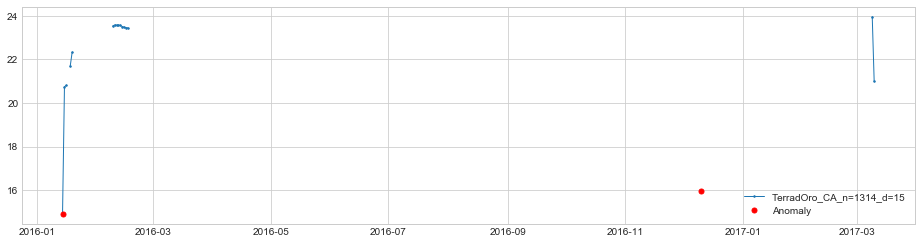

In [502]:
# for col in filtered.columns:
#     try:
#         s = filtered[col]
#         s.index = pd.DatetimeIndex(filtered.index)
#         s = validate_series(s)
#         iqr_ad = InterQuartileRangeAD(c=1.5)
#         anomalies = iqr_ad.fit_detect(s)
#         plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");
#         fig = plt.gcf()
#         fig.savefig('C:/Users/M Sonakshi/Documents/soil_imgs/anamolies/'+col+".png")
#         plt.close('all')
#     except Exception as e:
#         print(e)
#         print(s)

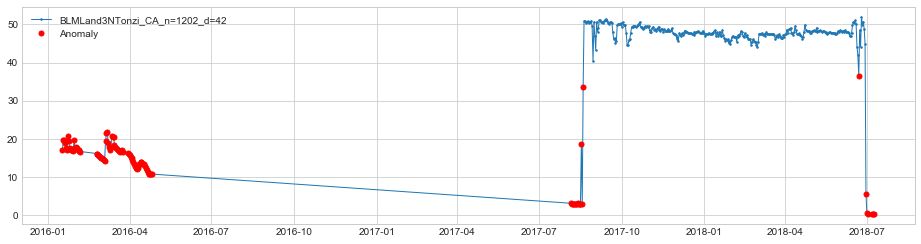

In [306]:
col = "BLMLand3NTonzi_CA_n=1202_d=42"
s1 = filtered[col]
s1.index = pd.to_datetime(filtered.index)
s1 =s1.dropna()
s = validate_series(s1)
iqr_ad = InterQuartileRangeAD(c=1.5)
anomalies = iqr_ad.fit_detect(s)
ax = plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");
# fig = plt.gcf()
# plt.xlabel('date')
# plt.ylabel('soil moisture')
# plt.title("SITE = " + "Kendall_AZ"+ ",  NODE_ID = " + "1406"+",  DEPTH = "+"15")
# fig.savefig('output.png')

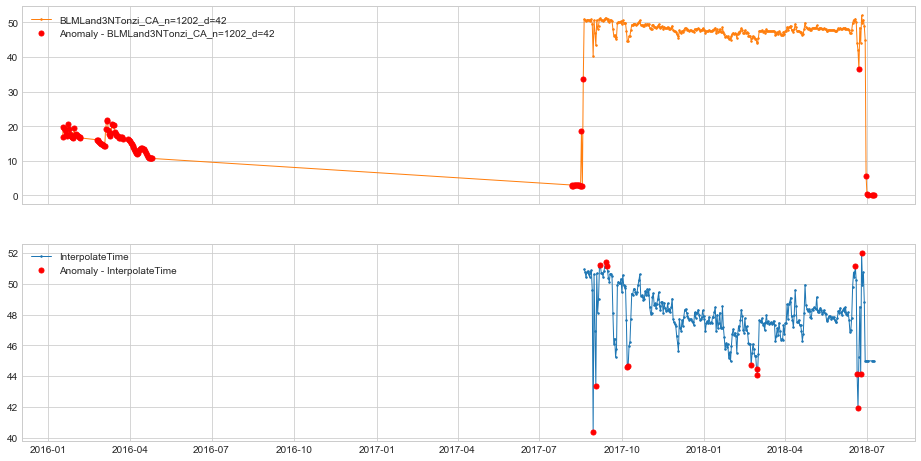

In [307]:
a=anomalies[~isNaN(anomalies)]
a=a[a>0]
s[s.index.isin(list(a.index))] = np.nan
s = pd.DataFrame(s)
samp=s
s = s.assign(InterpolateTime=s.interpolate(method='time'))
s[col] = s1
anomalies1 = iqr_ad.fit_detect(s)
ax = plot(s, anomaly=anomalies1, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

In [257]:
s['Kendall_AZ_n=1406_d=5'] = filtered['Kendall_AZ_n=1406_d=5']

In [270]:
s=s.InterpolateTime

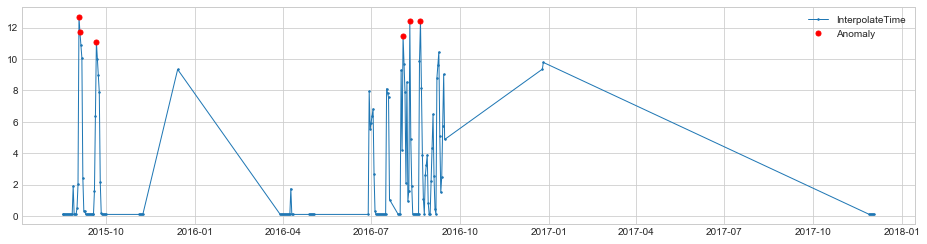

In [274]:
s = validate_series(s)
iqr_ad = InterQuartileRangeAD(c=1.5)
anomalies1 = iqr_ad.fit_detect(s)
ax = plot(s, anomaly=anomalies1, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

In [272]:
s.describe()

count    152.000000
mean       2.595868
std        3.773689
min        0.100000
25%        0.100000
50%        0.100000
75%        4.485500
max       12.689787
Name: InterpolateTime, dtype: float64

In [ ]:
ID = 'USC00028619'

In [102]:
cols = ['ID', 'YEAR', 'MONTH', 'ELEMENT']
def get_cols(cols):
    tot_cols = []
    tot_cols.extend(cols)
    for i in range(1, 32):
        tot_cols.extend(['VALUE' + str(i), 'MFLAG' + str(i), 'QFLAG' + str(i), 'SFLAG' + str(i)])
    return tot_cols


def get_width():
    vals = np.array([5, 1, 1, 1] * 31)
    w = [11, 4, 2, 4]
    w.extend(vals)
    return w


def get_filtered_cols(cols):
    filtered = []
    filtered.extend(cols)
    filtered.extend(['VALUE' + str(i) for i in range(1, 32)])
    return filtered


def melt_values(fil_data):
    melted_vals = fil_data.melt(id_vars=cols, value_name='VALUE')
    melted_vals['variable'] = melted_vals['variable'].apply(lambda x: int(x[5:]))
    melted_vals.sort_values(['YEAR', 'MONTH', 'variable'], inplace=True)
    return melted_vals


def filter_melted_data(element, filter_melted_df):
    filter_melted_df = filter_melted_df[filter_melted_df['ELEMENT'] == element]
    return filter_melted_df


def get_temp_data():
    data = pd.read_fwf('C:/Users/M Sonakshi/Downloads/' + ID + '.dly', widths=get_width(), names=get_cols(cols))
    fil_data = data[get_filtered_cols(cols)]
    melted_vals = melt_values(fil_data)
    melted_vals = melted_vals[melted_vals['VALUE'] != -9999]
    del fil_data
    return melted_vals


def filter_element_temp_data(element, melted_vals):
    # melted_vals = get_temp_data()
    print("temp data done")
    melted_vals = filter_melted_data(element, melted_vals)
    if melted_vals.empty:
        return melted_vals
    else:
        melted_vals['date'] = melted_vals.apply(
            lambda x: datetime.datetime(year=x['YEAR'], month=x['MONTH'], day=x['variable']), axis=1)
        return melted_vals


In [139]:
vals = get_temp_data()
dft = filter_element_temp_data('PRCP',vals)

temp data done


c:\users\msonak~1\penv\lib\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [140]:
# df[df['date']>'2011-01-01'].head()
dft = dft[['VALUE','date']]
dft['date'] = pd.to_datetime(dft['date'])

In [141]:
kcols = [i for i in filtered.columns if re.match("Kendall_AZ_*",i)]

In [142]:
kf = filtered[kcols]

In [143]:
kf=kf.reset_index()
kf['date'] = pd.to_datetime(kf['date'])


In [144]:
merged = kf.merge(dft, on='date')

In [145]:
merged.index= merged['date']
merged = merged.drop(columns=['date'])

In [203]:

merged.index = pd.to_datetime(merged.index)
m = merged[[i]]
s = validate_series(m)
iqr_ad = InterQuartileRangeAD(c=1.5)
anomalies = iqr_ad.fit_detect(s)
# plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3,ts_color="blue", anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

In [ ]:
value = merged['VALUE']

In [150]:
from sklearn import preprocessing

x = merged.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dfn = pd.DataFrame(x_scaled)

In [156]:
dfn.columns = merged.columns
dfn.index=merged.index

In [161]:
sample = dfn[["Kendall_AZ_n=1400_d=5",'VALUE']]
sample = sample.dropna()

In [163]:
sample.index

DatetimeIndex(['2015-08-17', '2015-08-18', '2015-08-19', '2015-08-20',
               '2015-08-21', '2015-08-22', '2015-08-23', '2015-08-24',
               '2015-08-25', '2015-08-26',
               ...
               '2019-02-11', '2019-02-16', '2019-02-17', '2019-03-01',
               '2019-03-02', '2019-03-03', '2019-03-06', '2019-03-08',
               '2019-03-14', '2019-03-26'],
              dtype='datetime64[ns]', name='date', length=1177, freq=None)

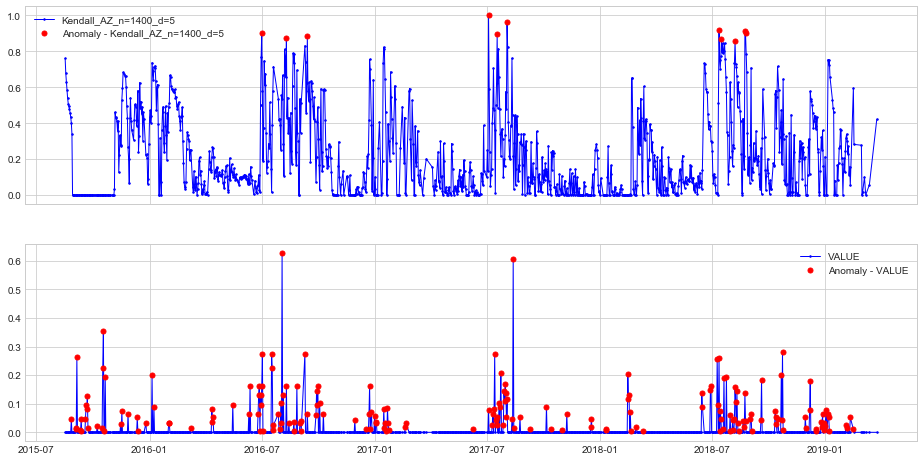

In [164]:
s = validate_series(sample)
iqr_ad = InterQuartileRangeAD(c=1.5)
anomalies = iqr_ad.fit_detect(s)
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3,ts_color="blue", anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

In [165]:
sample.corr()

,Kendall_AZ_n=1400_d=5,VALUE
Kendall_AZ_n=1400_d=5,1.000000,0.183841
VALUE,0.183841,1.000000
